In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
A300 = pd.read_excel('A300_daily.xls').dropna()
A500 = pd.read_excel('A500_daily.xls').dropna()
SPX = pd.read_excel('SPX_daily.xls').dropna()
HSI = pd.read_excel('HSI_daily.xls').dropna()

AU9999 = pd.read_excel('AU9999_daily.xls').dropna()

indices = {'A300':A300, 'A500':A500, 'SPX':SPX, 'HSI':HSI, 'AU9999':AU9999}

# 清洗数据
for name, index in indices.items():
    index = index.dropna()
    index = index[(index['交易时间'] >= '2008-01-01') & (index['交易时间'] <= '2023-01-01')]
    index = index.reset_index(drop=True)
    indices[name] = index   

#同步时间序列，直接删除不同市场区域不匹配的交易时间
for index, row in indices['A300'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['A300'].drop(index = index, inplace = True)
        indices['A500'].drop(index = index, inplace = True)
        indices['AU9999'].drop(index = index, inplace = True)
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['A300'].index.values:
            indices['A300'].drop(index = index, inplace = True)
        if index in indices['A500'].index.values:
            indices['A500'].drop(index = index, inplace = True)
        if index in indices['AU9999'].index.values:
            indices['AU9999'].drop(index = index, inplace = True)

for index, row in indices['SPX'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['SPX'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['SPX'].index.values:
            indices['SPX'].drop(index = index, inplace = True)

for index, row in indices['HSI'].iterrows():
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        indices['HSI'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['HSI'].index.values:
            indices['HSI'].drop(index = index, inplace = True)

for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)

In [188]:
# 应该确保不同区域市场时间序列大小一致
index_shape = set()
for name, index in indices.items():
    index_shape.add(index.shape[0])
if len(set(index_shape)) == 1:
    print('Pass')
else:
    print('Fail')

Pass


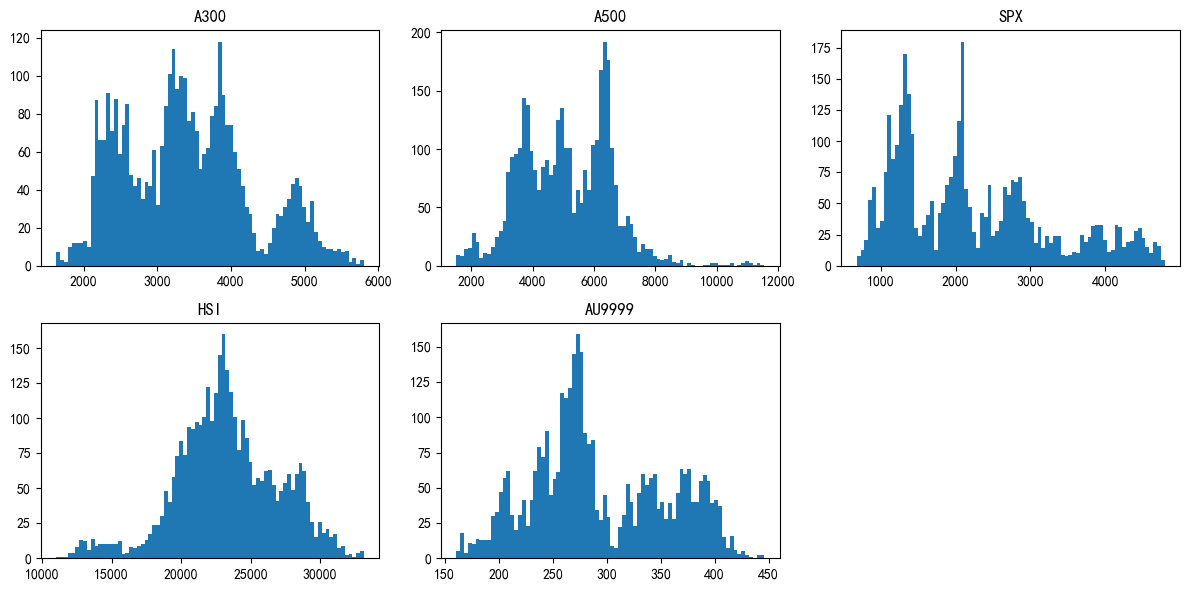

In [5]:
# 分布直方图

fig = plt.figure(figsize=(12, 6))
i = 1
for name, index in indices.items():
    ax = plt.subplot(2, 3, i)
    ax.set_title(name)
    plt.tight_layout()
    plt.hist(np.array(index['收盘价']), bins=80)
    i += 1

In [7]:
prices = np.array([[0] * 3460])
names = []
for name, index in indices.items():
    print(name, end=' ')
    names.append(name)
    prices = np.r_[prices, np.array(index['收盘价']).reshape(1,-1)]
prices = prices[1:].T

A300 A500 SPX HSI AU9999 

In [8]:
# 计算期望与协方差

Mu = prices.mean(axis = 0).reshape(-1, 1)
Sigma = np.cov(prices.T)
pd.DataFrame(np.corrcoef(prices.T), columns=names, index=names)   # 相关系数

,A300,A500,SPX,HSI,AU9999
A300,1.000000,0.788076,0.743082,0.593845,0.451829
A500,0.788076,1.000000,0.649532,0.523523,0.322699
SPX,0.743082,0.649532,1.000000,0.499714,0.669524
HSI,0.593845,0.523523,0.499714,1.000000,0.196278
AU9999,0.451829,0.322699,0.669524,0.196278,1.000000


In [9]:
pd.DataFrame(Sigma, columns=names, index=names)  # 协方差矩阵

,A300,A500,SPX,HSI,AU9999
A300,7.467926e+05,9.983564e+05,6.589595e+05,1.906033e+06,24049.900279
A500,9.983564e+05,2.148991e+06,9.771015e+05,2.850432e+06,29137.651792
SPX,6.589595e+05,9.771015e+05,1.053038e+06,1.904589e+06,42318.240109
HSI,1.906033e+06,2.850432e+06,1.904589e+06,1.379479e+07,44902.382362
AU9999,2.404990e+04,2.913765e+04,4.231824e+04,4.490238e+04,3793.841279


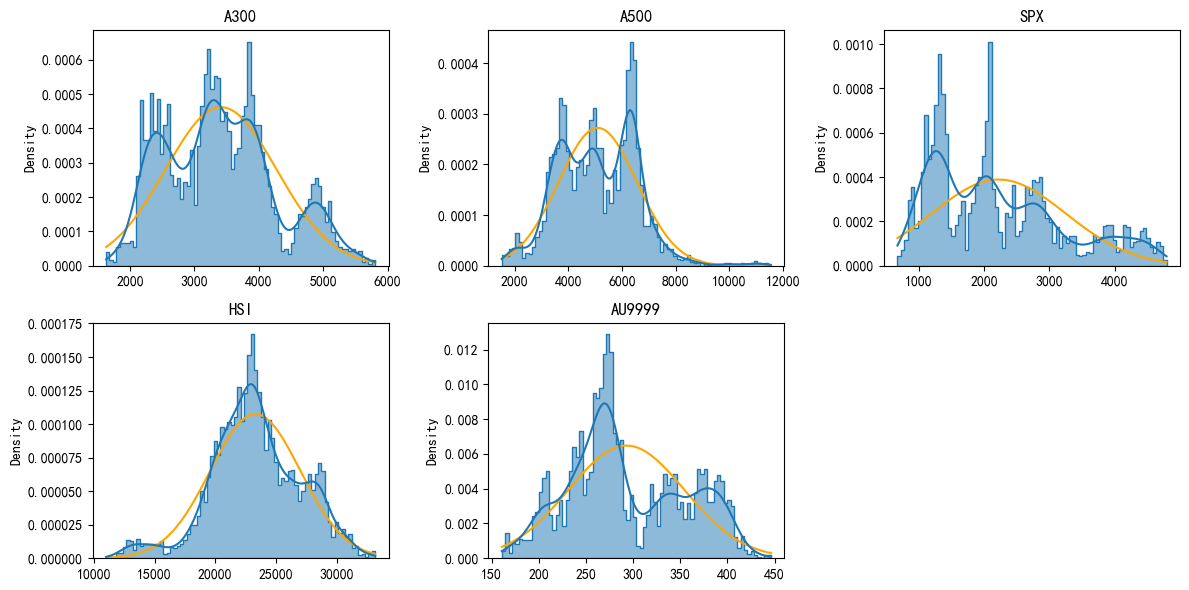

In [180]:
# 分布图
# 蓝色直方图，深蓝色核密度函数，橙色正态密度函数

fig = plt.figure(figsize=(12, 6))
i = 0
for name, index in indices.items():
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    price = np.array(index['收盘价'])
    norm_x = np.linspace(price.min(), price.max(), 1000)
    norm_y = scipy.stats.norm.pdf(norm_x, Mu[i], np.sqrt(Sigma[i,i]))
    plt.plot(norm_x,norm_y,c="orange")
    sns.histplot(data = price, bins = 80, kde=True, ax = ax, element="step", stat="density")
    i += 1

In [11]:
def prior2posterior(mu, q, mu_q, sigma, g, sigma_g):
    """
    Analytical solution to the constrain
    X ~ (Mu, Sigma)
    E(QX) = Mu_Q
    Cov(GX) = Sigma_G
    
    minimize the KL divergence
    
    X ~ (Mu_tilda, Sigma_tilda)
    
    See the following paper for more details.

    Meucci, Attilio, Fully Flexible Views: Theory and Practice (August 8, 2008). 
    Fully Flexible Views: Theory and Practice, Risk, Vol. 21, No. 10, pp. 97-102, October 2008. 
    Available at SSRN: https://ssrn.com/abstract=1213325
    
    
    """
    mu_tilda = sigma * q.T * np.linalg.inv(q * sigma * q.T) * (mu_q - q * mu)
    tmp = np.linalg.inv(g * sigma * g.T)
    sigma_tilda = sigma + (sigma * g.T) * (tmp * sigma_g * tmp - tmp) * (g*sigma)
    return mu_tilda, sigma_tilda

In [177]:
# 给定观点（随便设置的）
##### 期望
# 沪深300 - 中证500 = -1500
# 沪深300 - 中证500 = -1500
##### 协方差
# 协方差矩阵我也不知道怎么给随便设置了初始协方差

Q = np.matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])
Mu_Q = np.array([1.1 * Mu[0], 0.9 * Mu[1]]).reshape(-1, 1)

G = np.eye(1)
Sigma_G = 0.75 * Sigma

Mu_tilda, Sigma_tilda = prior2posterior(Mu, Q, Mu_Q, Sigma, G, Sigma_G)
Mu_tilda = np.array(Mu_tilda)

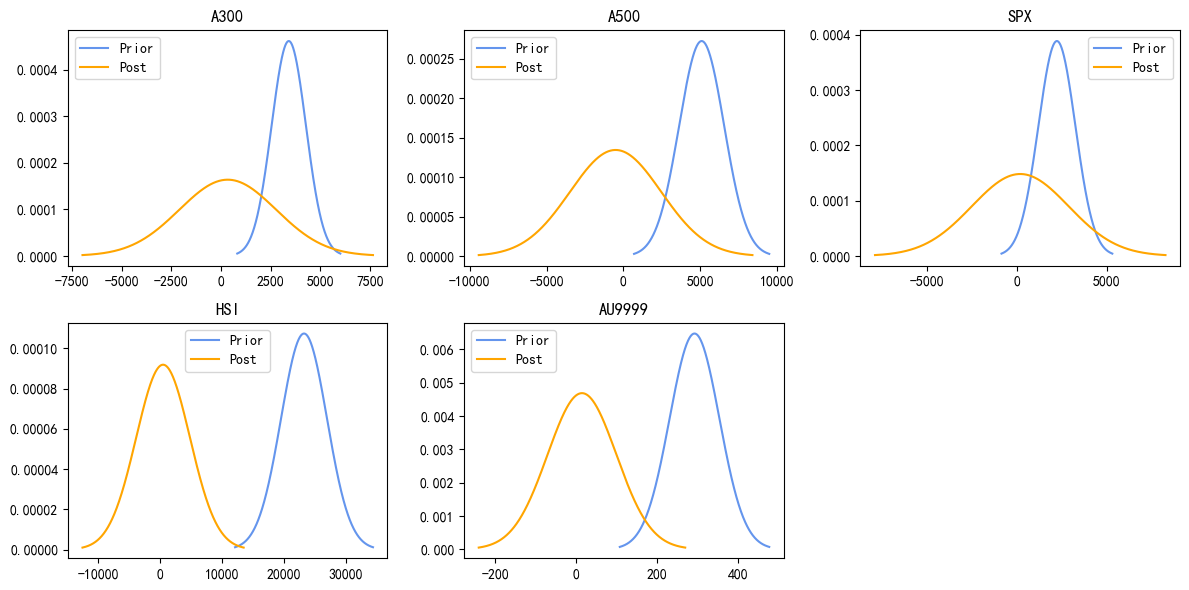

In [179]:
# 分布图
# 蓝色先验分布，橙色后验分布

fig = plt.figure(figsize=(12, 6))
for i, name in enumerate(names):
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    
    prior_norm_x = np.linspace(Mu[i] - 3 * np.sqrt(Sigma[i,i]),
                         Mu[i] + 3 * np.sqrt(Sigma[i,i]), 1000)
    post_norm_x = np.linspace(Mu_tilda[i] - 3 * np.sqrt(Sigma_tilda[i,i]),
                         Mu_tilda[i] + 3 * np.sqrt(Sigma_tilda[i,i]), 1000)
    
    prior_norm_y = scipy.stats.norm.pdf(prior_norm_x, Mu[i], np.sqrt(Sigma[i,i]))
    post_norm_y = scipy.stats.norm.pdf(post_norm_x, Mu_tilda[i], np.sqrt(Sigma_tilda[i,i]))
    
    plt.plot(prior_norm_x,prior_norm_y,c="cornflowerblue", label = 'Prior')
    plt.plot(post_norm_x,post_norm_y,c="orange", label = 'Post')
    plt.legend()